Students: Ayoub HAMMAL \& Quentin LE TELLIER

# Voice Conversion Using Neuro-Style Transfer


## Introduction

Voice conversion consists of reproducing an utterance in a different voice while keeping essentially the same linguistic content of the original utterance [1].
For this task, neuro-style transfer architectures were proposed first in the image processing field [2].
And, made their way to speech processing [1], by treating mel-spectrograms of audio signals indifferently from image data.

In this work, we will be reproducing the pipeline proposed by [1] for voice style transfer between different speakers, while upgrading some of the evaluation components to match the current state of the art.
And we will be experimenting additionally with the transfer of different phonetic properties aside from voice like emotions and tone.

We will explain and justify first the approach we chose taking into account the allotted time window and resources.

We will then describe every component of the pipeline, it's training and execution as well as the code structure that we chose.

We will discuss and compare the results obtained and do our best to draw meaningful conclusions and perspectives.

Finally, we will make a compilation of the difficulties we encountered and what we would have been able to upgrade if time did not cut us short.
We will articulate a series of propositions that would be interesting to explore in future work.


## Directory structure

Refer to the Appendix below for the complete project structure.


## This notebook

We used a remote server to run our scripts, we were not able to run the project on a notebook.

We made sure to checkpoint every step and log the outputs and useful information that we will use for visualization and analysis.

This notebook is an aggregation of the results of each component: we will visualize and explain the inputs and outputs of every step and we will analyze our findings.


## Dataset

We experimented with 2 different datasets: 
- [**Flickr8k Audio Caption Corpus**](https://groups.csail.mit.edu/sls/downloads/flickraudio/) for speaker voice transfer: that contains 40000 spoken captions of 8000 images. It contains the voices of 183 speakers with every speaker having from 4 to 2978 audio. The audio is sampled at 16000Hz with 16-bit depth and stored in Microsoft WAVE audio format.
- **Custom Tatiana emotion dataset** for emotion transfer: that contains 160 utterances in 7 different expressive conditions acted by a French female speaker (a total of 1120 sentences, 13140 vowels).

We will focus mainly on speaker voice transfer (the first dataset) and we will summarize the same procedure for emotion transfer at the end.

For our experiments, we will only need 2 speakers for reciprocal voice transfer (from A to B and from B to A).
We used the `organize_data.py` script to cluster the Flickr8k dataset by speaker (each speaker audio in a separate folder).
And we take only the speakers that we need for our experiment.

For this purpose, we tried choosing 2 speakers with very different voice characteristics: A mature man (speaker 7 with 2978 audio) and a mature woman (speaker 4 with 1690 audio).
We will be referring to them as speaker A and speaker B respectively.

The utterances of both speakers combined results in 4668 utterances, 20% of which are kept for test.


## Preprocessing

All audio throughout this project are assumed to have 16000kHz sampling rate, otherwise they are resampled.
All utterances are 1.9 seconds long and are then normalized to -30dB, and silences are removed using `webrtcvad` package for voiced audio detection.

We used the same parameters as the original paper [1] that can be found in `style_transfer/params.py`, the log mel-spectrogram has a window of 0.5 seconds with a 1/4 overlap which results in 128 frequency bands.
To feed the log mel-spectrogram to the model, we randomly crop 128 frames which generate a 128 x 128 input sample.

In order to preprocess the data, we run the `style_transfer/preprocess.py` script from the `style_transfer` folder with the following arguments:
```
$ python preprocess.py --model_name speaker_style_transfer --dataset ../organized_2spkr
```
The audio of each speaker is assumed to be in `A` and `B` sub-folders of the `--dataset` folder.


## Architecture and components

![](./resources/model_diagram.png)

We adopt a VAE-GAN architecture.
The model is composed of 3 components: the encoder, the generators and the discriminators.

- One unique encoder $E$ to process all the input audio and produce a hidden representation in a latent space: this has the effect of keeping only linguistic properties of the input utterances regardless of the phonetic characteristics. It is composed of a *feature extraction part* and a set of 4 *residual convolutional blocks*. The complete architecture can be found in `style_transfer/models.py`.
  
- One generator $G_{i}$ per speaker $i$ that takes a latent representation and reconstruct the original utterance: since the generator is unique per speaker, it will encode the phonetic characteristics and regenerate the utterance from the hidden representation that contains linguistic properties. Additionally, all the generators share the first layer that decodes the latent representation to accelerate training and enforces the shared-latent space assumption.

- One discriminator $D_{i}$ per speaker $i$ that discriminate between utterances of the speaker generated using its own generator and *fake* utterances generated using another speaker's generator.

More formally, as described in the paper [1], we can define the loss of the model as:
$$
    \ell = \lambda_{1} \ell_{VAE} + \lambda_{2} \ell_{GAN} + \lambda_{1} \ell_{CC} + \lambda_{3} \ell_{latent}
$$

Then given that:
- $S_{i}$ is the utterance of the speaker $i$ drawn from $P_{S_{i}}$.
- $S_{i \to j}$ is the transferred speech from speaker $i$ to $j$: $S_{i \to j} = G_{j} (E(S_{i}))$.
- $q(z_{i}|S_{i})$ is the latent posterior distribution given the speaker sample $S_{i}$.
- $p_{G_{i}} (S_{i}|z_{i})$ is the output posterior distribution of the generator $i$ given the latent representation $z_{i}$.

We can define:
- VAE loss: This is the loss of the reconstruction of sample $S_{i}$ using the encoder $E$ and the generator of the same speaker $G_{i}$:
$$
    \ell_{VAE} = \lambda_{4} \sum_{i} D_{KL} (q(z_{i}|S_{i})||p(z)) - \sum_{i} \mathbb{E}_{z_{i} \sim q(z_{i}|S_{i})} [\log p_{G_{i}}(S_{i}|z_{i})]
$$
- GAN loss: The Discriminator of speaker $i$ is trained to discriminate between correct samples $S_{i}$ and generated samples $S_{j \to i}$ from other speakers $j$:
$$
    \ell_{GAN} = \sum_{i} \mathbb{E}_{S_{i} \sim P_{S_{i}}} [\log D_{i} (S_{i})] + \sum_{i} \mathbb{E}_{S_{j \to i} \sim P_{G_{i}} (S_{j \to i}|z_{j})} [\log (1 - D_{i} (S_{j \to i}))]
$$
- Cycle Consistency (CC) loss: Once a generate sample $S_{i \to j}$ is created it is encoded back and re-generated using the initial speaker's $i$ generator $G_{i}$ to reconstruct the original sample $S_{i}$. This is making sure that the inverse transfer is sane, and that the shared-latent space is speaker independent.
$$
    \ell_{CC} = \lambda_{4} \sum_{i} D_{KL} (q(z_{j}|S_{i \to j})||p(z)) - \sum_{i, j} \mathbb{E}_{z_{j} \sim q(z_{j}|S_{i \to j})} [\log p_{G_{i}}(S_{i}|z_{j})]
$$
- Latent loss: The centroids $C_{i}$ and $C_{j}$ of the latent space generated by encoding the samples of each speaker $i$ and $j$ need to be as similar as possible since the latent space is supposed to be speaker independent. This is done by minimizing the distance between speakers' latent encoding centroids.
$$
    \ell_{latent} = |C_{i} - C_{j}| \qquad \text{with} \qquad C_{i} = \frac{1}{|P_{S_{i}}|} \sum_{S_{i} \in P_{S_{i}}} E(S_{i})
$$


## Training

We kept essentially the same hyperparameters as the original paper except for $\lambda_{2}$ which we set to 100 instead of 10, to enforce the GAN feedback; $\lambda_{1} = 100$, $\lambda_{3} = 10$, $\lambda_{4} = 1e-3$.

We used Adam optimizer with a learning rate of $1e-4$ and a batch size of 16 for 300 epochs.

The model checkpoint contains the model components' state dictionaries as well as the losses.

To run the training we run the training script `style_transfer/train.py` from the `style_transfer` folder using the following arguments:
```
$ python train.py --model_name speaker_style_transfer --dataset ../organized_2spkr --n_epochs 300 --decay_epoch 150 --batch_size 16
```
The script saves the checkpoint into `style_transfer/saved_models/<model_name>/` directory.

We extracted only the losses from the checkpoint and saved them to the resources folder attached to this notebook for visualization purposes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pickle
import IPython.display as ipd

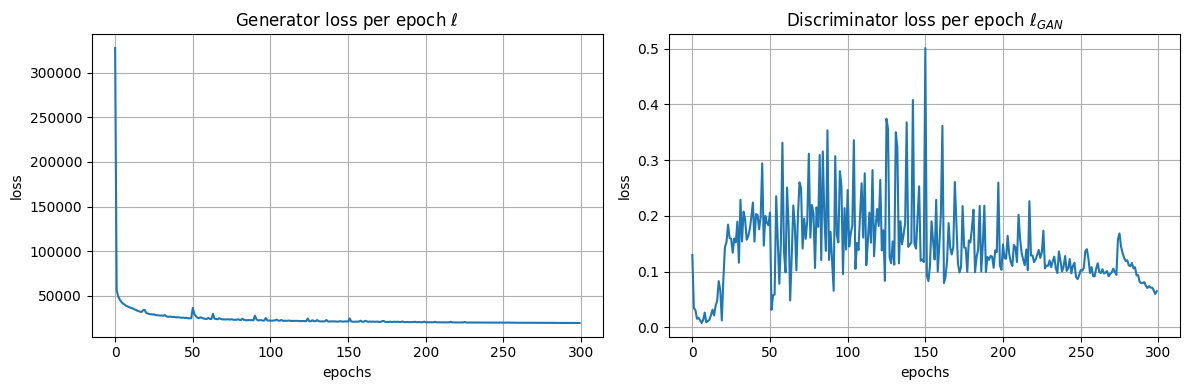

In [2]:
losses = pickle.load(open("resources/losses.pkl", "rb"))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(losses["G"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Generator loss per epoch $\ell$")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(losses["D"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Discriminator loss per epoch $\ell_{GAN}$")
plt.grid()

plt.tight_layout()
plt.show()

We can see from the plot below that the losses behave as expected during training; the generator loss decreases smoothly, whereas the discriminator part increases and stabilizes as the generator becomes better during training.


## Inference

In the original paper, the authors trained a wavenet vocoder on each speaker's utterances.

We were unsuccessful to run the wavenet vocoder from github.
We settled for MelGAN vocoder instead but training the vocoder on our speakers takes more time than what we can spare (1 day and a half for a single speaker).

So instead, we used the Fast Griffin-Lim algorithm to reconstruct the audio signal from the log mel-spectrograms available on `librosa`.
This gave us satisfactory results for the scope of this project.

We perform inference on the test set of our dataset that we kept aside using the `style_transfer/inference.py` script from the `style_transfer` folder with the following arguments:
```
$ python inference.py --model_name speaker_style_transfer --dataset ../organized_2spkr --epoch 299
```
The `epoch` argument indicates the epoch of the checkpoint of the model to use.
The script loads the checkpoint and transfers every sample of speaker A into speaker B voice and inversely.
And stores the resulting wav audio and log mel-spectrograms in the `style_transfer/inference_output/<model_name>/` directory.

We showcase below an example of transfer from speaker A (man) to speaker B (woman) voice, and inversely.

In [3]:
print("S1 of speaker A")
ipd.display(ipd.Audio(filename="resources/A.wav"))
print("S2 of speaker B")
ipd.display(ipd.Audio(filename="resources/B.wav"))
print("S1->2 speaker A to voice B")
ipd.display(ipd.Audio(filename="resources/A2B.wav"))
print("S2->1 speaker B to voice A")
ipd.display(ipd.Audio(filename="resources/B2A.wav"))

S1 of speaker A


S2 of speaker B


S1->2 speaker A to voice B


S2->1 speaker B to voice A


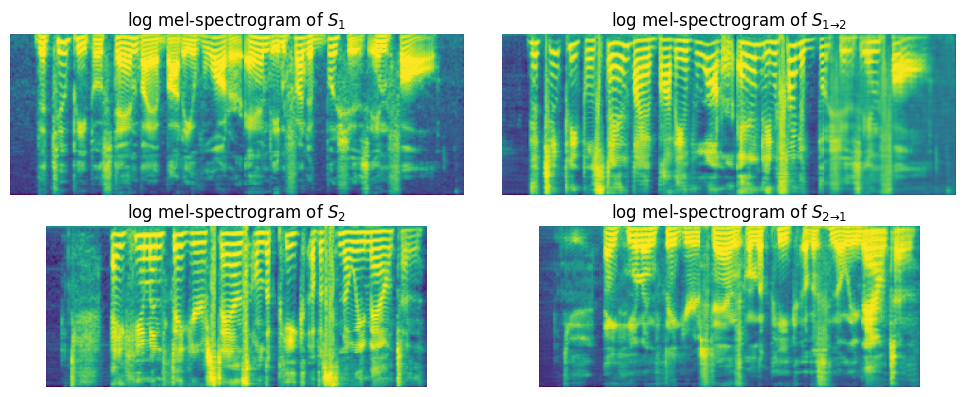

In [4]:
A_mel = np.load("resources/A.npy")
B_mel = np.load("resources/B.npy")
A2B_mel = np.load("resources/A2B.npy")
B2A_mel = np.load("resources/B2A.npy")

plt.figure(figsize=(10, 4))

plt.subplot(2, 2, 1)
plt.imshow(A_mel)
plt.axis("off")
plt.title("log mel-spectrogram of $S_{1}$")

plt.subplot(2, 2, 2)
plt.imshow(A2B_mel)
plt.axis("off")
plt.title("log mel-spectrogram of $S_{1 \\to 2}$")

plt.subplot(2, 2, 3)
plt.imshow(B_mel)
plt.axis("off")
plt.title("log mel-spectrogram of $S_{2}$")

plt.subplot(2, 2, 4)
plt.imshow(B2A_mel)
plt.axis("off")
plt.title("log mel-spectrogram of $S_{2 \\to 1}$")

plt.tight_layout()
plt.show()

We can perfectly hear the voice of speaker B in the audio A2B and inversely, hear the voice of speaker A in the audio B2A. 

We can make 2 observations from the previous audio samples:
- The reconstruction is metallic: this is an artifact of the Griffin-Lim vocoder.
- The voice at the end of the audio is not well transferred: and this is because the audio is cut into chunks of 128 frames each, and the last chunk is padded to reach 128 frames, which causes a low transfer quality.


## Evaluation

In the original paper, the authors adopted 3 evaluation strategies:
- Spoofing detection, using the GMM baseline model from ASV Spoofing 2019.
- Content verification using `SpeechRecognition` open-source library to calculate the Word Error Rate (WER).
- Speaker encoding metric to verify if the identity of the speaker is preserved using a simple RNN encoder.

We chose to use a different approach:
- We use Whisper speech to text model to get the transcripts of the original and transferred utterances, then we calculate the WER using the transcript of the original audio as reference.
- We train a wav2vec2 classifier to discriminate between our 2 speakers, and calculate its accuracy on the transferred utterances.

We decided to avoid testing our generated audio using the spoofing detection model, because we do not have a good vocoder and it is obviously easy to guess the generated audio from the originals.


### Content verification

To run the content verification metric, we run the script `metrics/content_verification/metric.py` from the `metrics/content_verification/` directory using the following arguments:
```
$ python metric.py --model_name speaker_style_transfer --dataset ../../organized_2spkr --eval_dataset ../../style_transfer/inference_output/speaker_style_transfer
```
The results of the evaluation are displayed below:

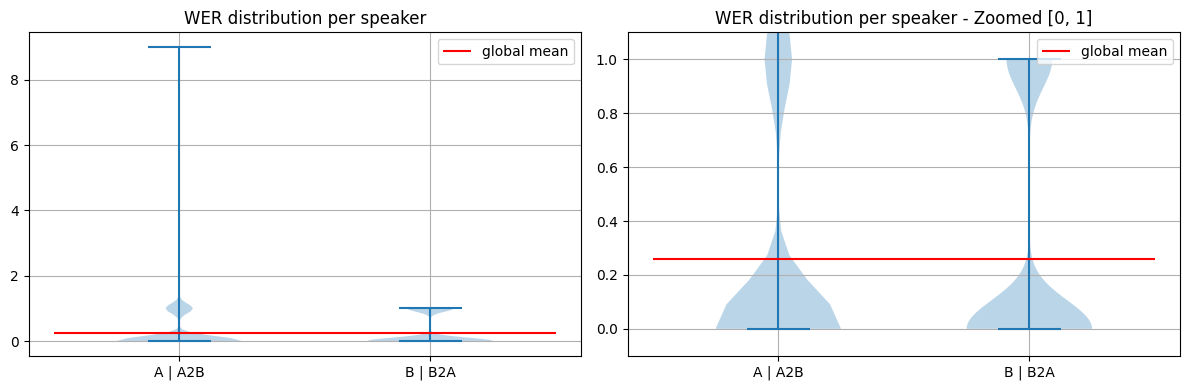

In [5]:
wers = pickle.load(open("resources/wers.pkl", "rb"))
werA = np.array(wers["A"])
werB = np.array(wers["B"])

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.violinplot([werA, werB])
plt.hlines(
    0.5 * werA.mean() + 0.5 * werB.mean(),
    xmin=0.5,
    xmax=2.5,
    colors="red",
    label="global mean",
)
plt.xticks([1, 2], ["A | A2B", "B | B2A"])
plt.legend()
plt.title("WER distribution per speaker")
plt.grid()

plt.subplot(1, 2, 2)
plt.violinplot([werA, werB])
plt.hlines(
    0.5 * werA.mean() + 0.5 * werB.mean(),
    xmin=0.5,
    xmax=2.5,
    colors="red",
    label="global mean",
)
plt.xticks([1, 2], ["A | A2B", "B | B2A"])
plt.ylim(-0.1, 1.1)
plt.legend()
plt.title("WER distribution per speaker - Zoomed [0, 1]")
plt.grid()

plt.tight_layout()
plt.show()

The generated audio has a 25.87% WER.
We can see that the utterances of each speaker are distributed into 2 very different categories: hard utterances and easy utterances, the hard ones getting a high WER when going through style transfer.

This degradation is mainly due to the vocoder that penalizes clarity of the utterance and generates additional artifacts in the resulting audio.


### Classification

We train a wav2vec2 + classifier model on distinguishing between the 2 speakers.
For this, we used the pre-trained wav2vec2-base model checkpoint from HuggingFace and 2 dense layers on top for classification.
We froze the feature extraction part of wav2vec2 during training, and performed 2 fine-tuning epochs using Adam optimizer with a $3e-5$ learning rate.

To train the classification model, we run the script `metrics/classification/metric.py` from the `metrics/classification` directory with the following arguments:
```
$ python train.py --model_name speaker_style_transfer --dataset ../../organized_2spkr
```
The model class, as well as the dataset class are in the `metrics/classification/model.py` script.
The resulting checkpoint will be saved into the `metrics/classification/saved_models/<model_name>/` folder.
The fine-tuned model obtained 98% accuracy on the original audio.

And we used it to classify the generated audio $S_{1 \to 2}$ the same class as $S_{2}$ and $S_{2 \to 1}$ the same class as $S_{1}$ to verify if the generated utterances are effectively classified as the target speaker's utterances.

To evaluate the audio using the classification model, we run the script `metrics/classification/metric.py` from the `metrics/classification` directory with the following arguments:
```
$ python metric.py --model_name speaker_style_transfer --dataset ../../organized_2spkr --eval_dataset ../../style_transfer/inference_output/speaker_style_transfer
```

We save the embeddings of each audio in the `metrics/classification/metric_output/<model_name>` folder, as well as the resulting accuracy.

We obtained a 93.86% accuracy on the generated audio.
Which means that the model faithfully recognizes the generated audio as their target class audio.
This means that the voice characteristics encoded in the resulting audio are those of the target speaker.
Note also that the performance of the model on $S_{1 \to 2}$ is better than that on $S_{2 \to 1}$, we will see why shortly.

We apply a dimensionality reduction algorithm (tSNE algorithm) to display below the embeddings of the audio passed through wav2vec2.

In [6]:
embeddings = pickle.load(open("resources/embeddings.pkl", "rb"))

x = np.array(embeddings["A"] + embeddings["B2A"] + embeddings["B"] + embeddings["A2B"])

tsne = TSNE(n_components=2)
x_2d = tsne.fit_transform(x)

embeddings_2d = {}
idx = 0
for key in embeddings.keys():
    embeddings_2d[key] = x_2d[idx : idx + len(embeddings[key])]
    idx += len(embeddings[key])

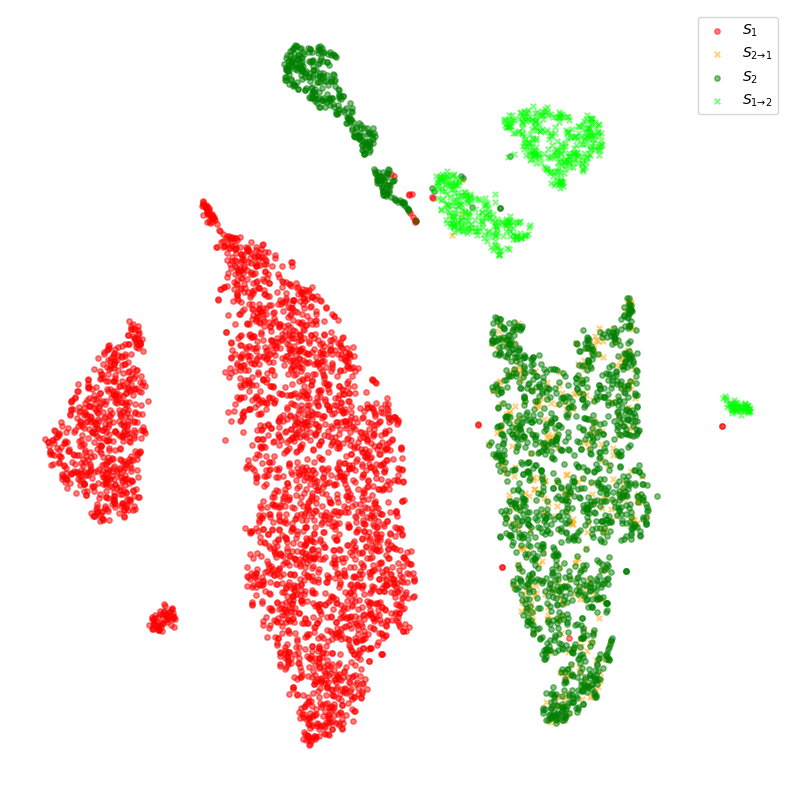

In [7]:
plt.figure(figsize=(10, 10))

s = 15
alpha = 0.5
plt.scatter(
    embeddings_2d["A"][:, 0],
    embeddings_2d["A"][:, 1],
    label="$S_{1}$",
    c="red",
    marker="o",
    alpha=alpha,
    s=s,
)
plt.scatter(
    embeddings_2d["B2A"][:, 0],
    embeddings_2d["B2A"][:, 1],
    label="$S_{2 \\to 1}$",
    c="orange",
    marker="x",
    alpha=alpha,
    s=s,
)
plt.scatter(
    embeddings_2d["B"][:, 0],
    embeddings_2d["B"][:, 1],
    label="$S_{2}$",
    c="green",
    marker="o",
    alpha=alpha,
    s=s,
)
plt.scatter(
    embeddings_2d["A2B"][:, 0],
    embeddings_2d["A2B"][:, 1],
    label="$S_{1 \\to 2}$",
    c="lime",
    marker="x",
    alpha=alpha,
    s=s,
)
plt.axis("off")
plt.legend()

plt.show()

The clusters of the original A and B speakers are well separated, we can see that the $S_{1 \to 2}$ cluster is very close to the cluster $S_{2}$.
Nevertheless, the cluster $S_{2 \to 1}$ is overlapping with cluster $S_{2}$ instead of cluster $S_{1}$ which is not the expected behavior.
This is consistent with the word error rate that is higher for $S_{2 \to 1}$ compared to $S_{1 \to 2}$; the model under performs when generating the woman's utterance using the man's voice.

The classifier seems to be able to distinguish between $S_{2 \to 1}$ and $S_{2}$ (high accuracy), so we will conclude that information must have been lost in the dimensionality reduction process for that cluster.

We should additionally keep in mind that our wav2vec2 model is pre-trained on other audio data, unlike for the paper's encoder that is specifically trained on the speakers audio.


## Emotion transfer

As we said before, we experimented additionally with emotion transfer between anger and sadness.

The results were not satisfactory and the model learned shortcuts to trick the discriminator such as reducing the volume of the angry voice to seem like a sad voice while keeping the angry tone.

Since the results did not pass our manual checking we considered the model unable to perform emotion transfer.

In [8]:
print("Angry to sad result")
ipd.display(ipd.Audio(filename="resources/angry_low.wav"))

Angry to sad result


# Difficulties and perspectives

One of the main constraints we encountered was time.
We were not able to utilize our own fine-tuned vocoder.

Vocoder training typically takes a lot of time and its usage would have definitely made a big difference in the results.

We observed several inconsistencies in the choice of the pipeline components.
If we were given more time, we would have changed the following points in the architecture:

We would have trained the vocoder as part of the pipeline, and instead of using a convolutional discriminator on mel-spectrograms (as inherited from the original image style transfer paper), we would have used wav2vec2 classifier on audio signal generated by the vocoder.
This not only gives a better discriminative ground, especially for voice classification. But also allows us to train all the needed components at the same time. 
```
[E] -(KL loss)-> [G] -(mel-spect reconstruction loss)-> [vocoder] -(audio reconstruction loss)-> [D: wav2vec2] -(classification (gan) loss)->
```


# References

[1] AlBadawy, E.A., Lyu, S. (2020) Voice Conversion Using Speech-to-Speech Neuro-Style Transfer. Proc. Interspeech 2020, 4726-4730, doi: 10.21437/Interspeech.2020-3056.

[2] Liu, Ming-Yu, Thomas Breuel, and Jan Kautz. "Unsupervised image-to-image translation networks." Advances in neural information processing systems 30 (2017).


# Appendix


## Directory structure

Each output or checkpoint directory has 2 levels: the model name directory (e.g. `speaker_style_transfer`) then the actual results/checkpoints.

```
.
├── main.ipynb                                    -- this current notebook
├── resources                                     -- resource directory for the main.ipynb plots
│   └── model_diagram.png
│
│
├── organize_data.py                              -- script to organize Flickr8k audio to one directory per speaker
│
├── organized_2emo                                -- the organized dataset for emotion transfer
│   ├── A                                            -- category A wav files directory
│   │   ... // wav files                                --
│   ├── B                                            -- category B wav files directory
│   │   ... // wav files                                --
│   ├── emotion_transfer_test.pickle                 -- preprocessed organized dataset - test split
│   └── emotion_transfer_train.pickle                -- preprocessed organized dataset - train split
├── organized_2spkr                               -- the organized dataset for speaker style transfer
│   ├── A                                            -- category A wav files directory
│   │   ... // wav files                                --
│   ├── B                                            -- category B wav files directory
│   │   ... // wav files                                --
│   ├── speaker_style_transfer_test.pickle           -- preprocessed organized dataset - test split
│   └── speaker_style_transfer_train.pickle          -- preprocessed organized dataset - train split
│
│
├── style_transfer                                -- the main code directory for style transfer model training and inference
│   ├── params.py                                    -- the parameters of the preprocessing
│   ├── utils.py                                     -- utility functions for preprocessing and inference
│   ├── preprocess.py                                -- the preprocessing script: takes a path to data directory with A and B sub directories and produces train and test pickles
│   ├── data_proc.py                                 -- the Dataset classes
│   ├── models.py                                    -- the model classes used for encoder, generator and discriminator
│   ├── inference.py                                 -- the inference script to transfer A to B and B to A, produce directory inference_output
│   ├── train.py                                     -- the train script, train model on pickle datasets and produces checkpoints
│   │
│   ├── saved_models                                 -- directory to save model checkpoints for every dataset
│   │   ├── emotion_transfer                            --
│   │   │   └── checkpoint_299.pth                         -- the checkpint containing state dict of each component and the losses
│   │   └── speaker_style_transfer                      --
│   │       └── checkpoint_299.pth                         --
│   └── inference_output                             -- the output of the inference: transfer from A to B and from B to A per dataset from the pickle dataset
│       ├── speaker_style_transfer                      -- the output of the speaker style transfer dataset
│       │   ├── A                                          -- the original A audio reconstructed from their mel spectrogram for reference
│       │   │   ... // wav files                              --
│       │   ├── A2B                                        -- the audio of A transfered to B
│       │   │   ... // wav files                              --
│       │   ├── A2B_mel                                    -- the mel spectrogram of A to B transfer in numpy array
│       │   │   ... // npy files                              --
│       │   ├── A_mel                                      -- the mel spectrogram of A in numpy array
│       │   │   ... // npy files                              --
│       │   ├── B                                          -- the original B audio reconstructed from their mel spectrogram for reference
│       │   │   ... // wav files                              --
│       │   ├── B2A                                        -- the audio of B transfered to A
│       │   │   ... // wav files                              --
│       │   ├── B2A_mel                                    -- the mel spectrogram of B to A transfer in numpy array
│       │   │   ... // npy files                              --
│       │   └── B_mel                                      -- the mel spectrogram of B in numpy array
│       │       ... // npy files                              --
│       └── emotion_transfer                            --
│               ... // the same as speaker_style_transfer  --
│
│
└── metrics                                       -- the metrics used
    │
    ├── classification                               -- classification metric
    │   ├── model.py                                    -- the wav2vec2 model used for classification as well as the dataset class
    │   ├── train.py                                    -- the script to train wav2vec2 for classification
    │   ├── metric.py                                   -- the script to run the metric using the trained wav2vec2 checkpoint
    │   ├── metric_output                               -- the output of the classification metric for each model
    │   │   └── speaker_style_transfer                     -- 
    │   │       ├── classification_accuracy.txt               -- the accuracy of the generated utterances
    │   │       └── embeddings.pkl                            -- the embeddings of the original and generated utterances
    │   └── saved_models                                -- the checkpoint for the trained wav2vec2 classification model
    │       └── speaker_style_transfer                     --
    │           └── checkpoint_wav2vec2.pth                   --
    │
    └── content_verification                                -- the content verification metric
        ├── metric.py                                   -- the script to the metric using pre-trained whisper
        └── metric_output                               -- the output of the content verification metric for each model
            └── speaker_style_transfer                     --
                ├── wers.pkl                                  -- arrays of wer per speaker A and B
                └── wer.txt                                   -- average wer per speaker A and B
```